# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [95]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [96]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 15, 2, 10, 6, 542237)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [97]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167510
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [98]:
feature_view = fs.get_feature_view(
    name='air_quality_fv_lagging_feature',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [99]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_lagging_feature_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [100]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model-lagging-feature.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5503822E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast And Lagging PM25 Features with Feature View   </span>



In [105]:
weather_fg = fs.get_feature_group(
    name='weather_lagging_feature',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-16 00:00:00+00:00,9.45,0.0,20.150354,251.241257,stockholm
1,2024-11-21 00:00:00+00:00,2.75,0.0,18.171976,213.690094,stockholm
2,2024-11-17 00:00:00+00:00,6.15,0.0,16.595179,245.658920,stockholm
3,2024-11-22 00:00:00+00:00,0.95,0.1,8.913181,313.363464,stockholm
4,2024-11-18 00:00:00+00:00,2.80,0.0,11.542478,273.576263,stockholm
5,2024-11-19 00:00:00+00:00,0.55,0.0,5.937272,75.963730,stockholm
6,2024-11-24 00:00:00+00:00,0.05,0.2,4.510787,331.389618,stockholm
7,2024-11-23 00:00:00+00:00,-1.15,0.0,6.989935,281.888641,stockholm
8,2024-11-20 00:00:00+00:00,2.45,0.3,24.606731,200.556122,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [106]:
# === LAGGING FEATURE ===
# We need to make predictions for 1 day out, but we don't have the pm25 reading for this day to compute the rolling mean
# This is the paradigm we will follow (we know true values x, x-1, x-2, ... -- where day x+1 is the first day we want to predict):
# For 1 day out -- pred_(x+1) <- mean(real_x, real_(x-1), real_(x-2))
# For 2 days out -- day (x+2), take mean of pred_(x+1) + true_x + true(x-1) as pm25_rolling_window and make prediction = prex_(x+2)
# For 3 days out -- pred_(x+3) <- mean(pred_(x+2) + pred_(x+1) + true_x)
# For 4 days out -- pred_(x+4) <- mean(pred_(x+3) + pred_(x+2) + pred_(x+1))
# For 5 days out -- pred_(x+5) <- mean(pred_(x+4) + pred_(x+3) + pred_(x+2))
# For 6 days out -- pred_(x+6) <- mean(pred_(x+5) + pred_(x+4) + pred_(x+3))
# For 7 days out -- pred_(x+7) <- mean(pred_(x+6) + pred_(x+5) + pred_(x+4))
# For 8 days out -- pred_(x+8) <- mean(pred_(x+7) + pred_(x+6) + pred_(x+5))
# For 9 days out -- pred_(x+9) <- mean(pred_(x+8) + pred_(x+7) + pred_(x+6
# Note: Because of how Pandas "rolling..." works, this means that for forecasting predictions, we'll be "1 day behind" in terms of rolling
# the average. For training, for day x, the average was taken for x + x-1 + x-2 days (based on the rolling operator). But for forecasting
# we don't have the pm25 value for the day we are trying to predict. So, we use this "off by one" tactic. 

# Get the latest 2 air-quality values
air_quality_fg = fs.get_feature_group(
    name='air_quality_lagging_feature',
    version=1,
)
prev_2day_aq = air_quality_fg.read().set_index("date").sort_index(ascending=False).head(3)

# We do the [::-1] in the end because we want the first aq value to be for day x-2, then x-1, then day x. We will keep adding predicted
# aq values to this array.
prev_aq_vals = [curr["pm25"] for _, curr in prev_2day_aq.iterrows()][::-1]
# Array to store the predictions and the rolling pm value. will be added to the batched data later for reporting purposes
predictions, rolling_pm_values = [], []

for idx, curr in batch_data.set_index("date").sort_index().iterrows():
    curr_df = pd.DataFrame([curr])
    curr_rolling_mean = sum(prev_aq_vals[-3:]) / 3
    curr_df['pm25_lagging_3day_mean'] = curr_rolling_mean
    curr_prediction = retrieved_xgboost_model.predict(curr_df[['pm25_lagging_3day_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    # Add the values to the arrays for the current prediction made and for the current rolling mean
    prev_aq_vals.append(curr_prediction)
    predictions.append(curr_prediction)
    rolling_pm_values.append(curr_rolling_mean)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


In [107]:
# === LAGGING FEATURE ===
# Now we want to add the predictions and the rolling-mean to the batch data, so that we get a consistent view
# (like with the old batch_data). 

# 1. Get the first date from the sorted batch data
first_date = batch_data.sort_values(by="date").iloc[0]["date"]
date_range = pd.date_range(start=first_date, periods=len(predictions), freq='D')

# 2. Create the data frames
predictions_df = pd.DataFrame({ "date": date_range, "predicted_pm25": list(map(float, predictions)) })
rolling_pm_values_df = pd.DataFrame({ "date": date_range, "pm25_lagging_3day_mean": list(map(float, rolling_pm_values)) })

# 3. Do the intermediate join of the two
intermediate_df = pd.merge(predictions_df, rolling_pm_values_df, on="date", how="inner")
intermediate_df

# 4. Join this intermediate df with the batch_data to get all the values
batch_data = pd.merge(intermediate_df, batch_data, on="date", how="inner")
batch_data

2024-11-15 02:18:24,820 WARNING: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

2024-11-15 02:18:24,822 WARNING: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,date,predicted_pm25,pm25_lagging_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-16 00:00:00+00:00,16.752684,15.666667,9.45,0.0,20.150354,251.241257,stockholm
1,2024-11-17 00:00:00+00:00,15.983923,15.250896,6.15,0.0,16.595179,245.658920,stockholm
2,2024-11-18 00:00:00+00:00,21.447092,16.578871,2.80,0.0,11.542478,273.576263,stockholm
3,2024-11-19 00:00:00+00:00,27.858522,18.061234,0.55,0.0,5.937272,75.963730,stockholm
4,2024-11-20 00:00:00+00:00,29.654724,21.763178,2.45,0.3,24.606731,200.556122,stockholm
5,2024-11-21 00:00:00+00:00,28.644798,26.320114,2.75,0.0,18.171976,213.690094,stockholm
6,2024-11-22 00:00:00+00:00,35.099323,28.719347,0.95,0.1,8.913181,313.363464,stockholm
7,2024-11-23 00:00:00+00:00,30.864676,31.132950,-1.15,0.0,6.989935,281.888641,stockholm
8,2024-11-24 00:00:00+00:00,35.060184,31.536264,0.05,0.2,4.510787,331.389618,stockholm


In [108]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[ns, UTC]
 1   predicted_pm25               9 non-null      float64            
 2   pm25_lagging_3day_mean       9 non-null      float64            
 3   temperature_2m_mean          9 non-null      float32            
 4   precipitation_sum            9 non-null      float32            
 5   wind_speed_10m_max           9 non-null      float32            
 6   wind_direction_10m_dominant  9 non-null      float32            
 7   city                         9 non-null      object             
dtypes: datetime64[ns, UTC](1), float32(4), float64(2), object(1)
memory usage: 560.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [109]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,predicted_pm25,pm25_lagging_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day
0,2024-11-16 00:00:00+00:00,16.752684,15.666667,9.45,0.0,20.150354,251.241257,stockholm,stockholm-hornsgatan-108,sweden,1
1,2024-11-17 00:00:00+00:00,15.983923,15.250896,6.15,0.0,16.595179,245.658920,stockholm,stockholm-hornsgatan-108,sweden,2
2,2024-11-18 00:00:00+00:00,21.447092,16.578871,2.80,0.0,11.542478,273.576263,stockholm,stockholm-hornsgatan-108,sweden,3
3,2024-11-19 00:00:00+00:00,27.858522,18.061234,0.55,0.0,5.937272,75.963730,stockholm,stockholm-hornsgatan-108,sweden,4
4,2024-11-20 00:00:00+00:00,29.654724,21.763178,2.45,0.3,24.606731,200.556122,stockholm,stockholm-hornsgatan-108,sweden,5
5,2024-11-21 00:00:00+00:00,28.644798,26.320114,2.75,0.0,18.171976,213.690094,stockholm,stockholm-hornsgatan-108,sweden,6
6,2024-11-22 00:00:00+00:00,35.099323,28.719347,0.95,0.1,8.913181,313.363464,stockholm,stockholm-hornsgatan-108,sweden,7
7,2024-11-23 00:00:00+00:00,30.864676,31.132950,-1.15,0.0,6.989935,281.888641,stockholm,stockholm-hornsgatan-108,sweden,8
8,2024-11-24 00:00:00+00:00,35.060184,31.536264,0.05,0.2,4.510787,331.389618,stockholm,stockholm-hornsgatan-108,sweden,9


In [110]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[ns, UTC]
 1   predicted_pm25               9 non-null      float64            
 2   pm25_lagging_3day_mean       9 non-null      float64            
 3   temperature_2m_mean          9 non-null      float32            
 4   precipitation_sum            9 non-null      float32            
 5   wind_speed_10m_max           9 non-null      float32            
 6   wind_direction_10m_dominant  9 non-null      float32            
 7   city                         9 non-null      object             
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

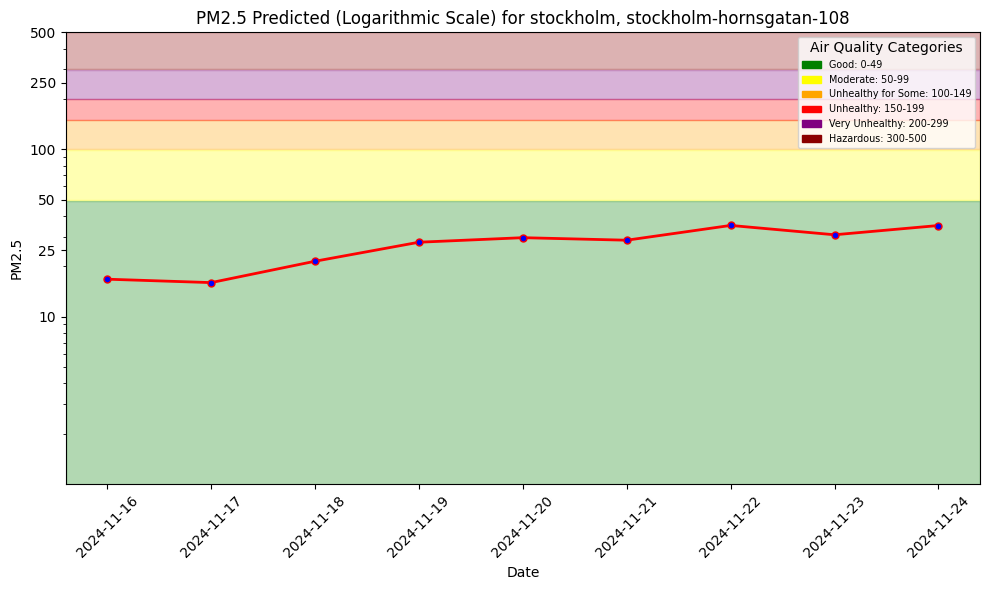

In [111]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast_lagging_feature.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [112]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_lagging_feature',
    description='Air Quality prediction monitoring (with lagging feature)',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [113]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1167510/fs/1158213/fg/1348943


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_lagging_feature_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1167510/jobs/named/aq_predictions_lagging_feature_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x302d8e3b0>, None)

In [114]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


,date,predicted_pm25,pm25_lagging_3day_mean,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day
0,2024-11-16 00:00:00+00:00,16.752684,15.666667,9.45,0.0,20.150354,251.241257,stockholm,stockholm-hornsgatan-108,sweden,1


In [115]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_lagging_feature',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 


,date,pm25_lagging_3day_mean,pm25,country,city,street,url
0,2019-03-31 00:00:00+00:00,38.333333,31.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
1,2024-10-20 00:00:00+00:00,27.333333,48.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2,2019-05-12 00:00:00+00:00,37.666667,30.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
3,2020-07-17 00:00:00+00:00,20.666667,16.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
4,2020-10-21 00:00:00+00:00,9.333333,50.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
...,...,...,...,...,...,...,...
2512,2021-12-03 00:00:00+00:00,21.666667,25.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2513,2024-01-25 00:00:00+00:00,15.666667,9.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2514,2018-11-18 00:00:00+00:00,43.000000,37.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009
2515,2019-10-20 00:00:00+00:00,26.000000,30.0,sweden,stockholm,stockholm-hornsgatan-108,https://api.waqi.info/feed/@10009


In [116]:
# === LAGGING FEATURE ===
# Adding helper function here, as couldn't get it to be imported from util for some reason
def backfill_predictions_for_monitoring_lagging_feature(weather_fg, air_quality_df, monitor_fg, model):
    weather_df = weather_fg.read()
    weather_df = weather_df.sort_values(by=['date'], ascending=True)
    weather_df = weather_df.tail(10)
    features_df = pd.merge(weather_df, air_quality_df[['pm25_lagging_3day_mean', 'date']], on="date", how="inner")
    features_df['predicted_pm25'] = model.predict(features_df[['pm25_lagging_3day_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date', 'pm25', 'street', 'country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    df["pm25_lagging_3day_mean"] = df["pm25_lagging_3day_mean"].astype('float64')
    df["predicted_pm25"] = df["predicted_pm25"].astype('float64')
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring_lagging_feature(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_lagging_feature_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1167510/jobs/named/aq_predictions_lagging_feature_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lagging_3day_mean,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,7.45,0.0,8.707237,240.255203,stockholm,14.0,19.924984,17.0,stockholm-hornsgatan-108,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

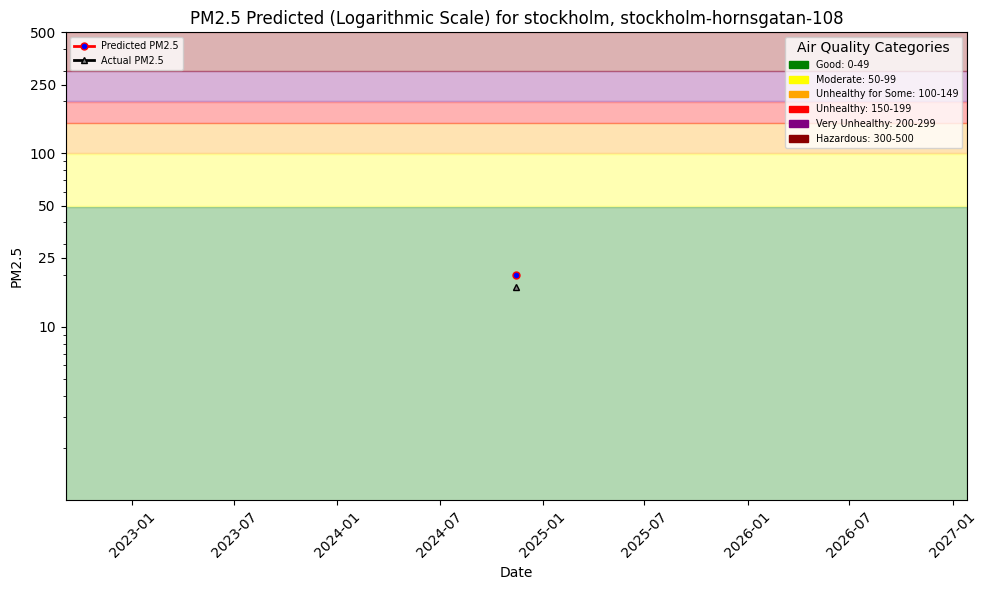

In [117]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day_lagging_feature.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---